In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Conv1D
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.multivariate.pca import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,6.27)})

from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import LeakyReLU

model_type = []
global model_type



def update_model_type(var):
    model_type.append(var)

sample = []
global sample



def update_sample(var):
    sample.append(var)





/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#IMPORT VIABLE DATA
df = pd.read_csv("viable_dataset.csv", index_col="Date")

In [ ]:
df.corr()['BIOGAS_PRODUCTION_Q_DAY'].abs().sort_values(ascending=False)

BIOGAS_PRODUCTION_Q_DAY                           1.000000
TPS_Q1_DAY                                        0.149911
PS_Q_DAY                                          0.148351
DIGESTED_SLUDGE_QOUT_DAY                          0.130412
DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK    0.079594
TWAS_DAF_QIN_DAY                                  0.061662
Name: BIOGAS_PRODUCTION_Q_DAY, dtype: float64

In [ ]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

def smooth(dataset, train_split, smooth_level):
  for column in dataset.columns:
    data = dataset[column]
    exp = ExponentialSmoothing(data[:train_split])
    exp_model = exp.fit(smoothing_level=smooth_level)
    result = exp_model.fittedvalues
    dataset[column][:train_split] = result
    return dataset

class UndefinedModelError(Exception):
    """Please input either 'discrete' or 'time-window' as model type"""
    def __init__(self, message="Please input either 'discrete' or 'time-window' as model type and Specify Inputs"):
        self.message = message
        super().__init__(self.message)
    pass

In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
test_split = int((split_fraction+0.15) * int(df.shape[0]))
step = 1
future =1


learning_rate = 0.001
batch_size = 1
epochs = 5

In [ ]:
cols = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
selected_features = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.set_index(df.index, inplace=True)
#print(features.head())

features = smooth(features, train_split, smooth_level=0.2)
#print(features.head())

#features = normalize(features.values, train_split)
features = pd.DataFrame(features.values)
#print(features.head())



train_data = features.loc[0 : train_split]
test_data = features.loc[train_split:test_split]
val_data = features.loc[test_split:]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
def generate_classical_dataset(past, future):
  
  start = past + future
  end = start + train_split

  x_train = train_data[[0, 1, 2, 3, 5]].values
  y_train = features.iloc[start:end][[4]]

  sequence_length = int(past / step)

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

  start = test_split + past + future
  end = start+test_split

  x_val = val_data[[0,1,2,3,5]].values
  y_val = features.iloc[start:end][[4]]

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
      x_val,
      y_val,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )



  start = train_split + past + future
  end = start+test_split

  x_test = test_data[[0, 1, 2, 3, 5]].values
  y_test = features.iloc[start:end][[4]]

  dataset_test = keras.preprocessing.timeseries_dataset_from_array(
      x_test,
      y_test,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )


  return dataset_train, dataset_val, dataset_test

In [ ]:
def build_model(mtype, inputs):

  if mtype=='discrete':
    kernel_size = 1
  elif mtype=='time-window':
    kernel_size = 2
  else:
    raise UndefinedModelError

  inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
  lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  cnn = Conv1D(filters=32, kernel_size=kernel_size, activation=lrelu)(inputs)
  cnn = Conv1D(filters=64, kernel_size=kernel_size, activation=lrelu)(cnn)

  cnn = Flatten()(cnn)

  dense = Dense(50, activation=lrelu)(cnn)
  output = Dense(1)(dense)

  model = keras.Model(inputs=inputs, outputs=output)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
  return model

In [ ]:
def get_callbacks(patience=5):
  path_checkpoint = "model_checkpoint.h5"
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=patience)

  modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
  )

  return es_callback, modelckpt_callback

In [ ]:
def train_model(model, es_callback, modelckpt_callback, dataset_train, dataset_val):
  history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
  return model, history

In [ ]:
def make_discrete_data_cnn_model(retrain = False, model = None, history=None):
  update_model_type('discrete')
  past = 1
  future = 1
  dataset_train, dataset_val, dataset_test= generate_classical_dataset(past, future)
  es_callback, modelckpt_callback = get_callbacks(patience = 3)
  for batch in dataset_train.take(1):
    inputs, targets = batch
  print("Input shape:", inputs.numpy().shape)
  print("Target shape:", targets.numpy().shape)
  if not retrain:
    model= build_model(model_type[-1], inputs)
  

  return train_model(model, es_callback, modelckpt_callback, dataset_train, dataset_val)





In [ ]:
def make_time_window_cnn_model(retrain = False, model = None, history=None):
  update_model_type('time-window')
  past = 3
  future = 1
  dataset_train, dataset_val, dataset_test= generate_classical_dataset(past, future)
  es_callback, modelckpt_callback = get_callbacks(3)
  for batch in dataset_train.take(1):
    inputs, targets = batch
  print("Input shape:", inputs.numpy().shape)
  print("Target shape:", targets.numpy().shape)
  if not retrain:
    model= build_model(model_type[-1], inputs)
  
  
  return train_model(model, es_callback, modelckpt_callback, dataset_train, dataset_val)

In [ ]:
model, history= make_time_window_cnn_model()
while np.min(history.history['val_loss'])>0.18:
  model, history = make_time_window_cnn_model(retrain = True, model=model, history=history)
#model, history = make_time_window_cnn_model(retrain = True, model=model, history=history) # To use Checkpoints

Input shape: (1, 3, 5)
Target shape: (1, 1)
Epoch 1/100
594/594 [==============================] - 3s 4ms/step - loss: 150.7673 - val_loss: 28.2765
Epoch 2/100
594/594 [==============================] - 2s 3ms/step - loss: 23.9851 - val_loss: 14.2180
Epoch 3/100
594/594 [==============================] - 2s 3ms/step - loss: 12.0047 - val_loss: 34.7093
Epoch 4/100
594/594 [==============================] - 2s 3ms/step - loss: 6.6755 - val_loss: 31.2385
Epoch 5/100
122/594 [=====>........................] - ETA: 1s - loss: 5.0651

KeyboardInterrupt: ignored

In [ ]:
model, history= make_discrete_data_cnn_model()
#model, history = make_discrete_data_cnn_model(retrain = True, model=model, history=history) # To use Checkpoints

Input shape: (1, 1, 5)
Target shape: (1, 1)
Epoch 1/5
596/596 [==============================] - 2s 3ms/step - loss: 142.3010 - val_loss: 1.6336
Epoch 2/5
596/596 [==============================] - 2s 3ms/step - loss: 3.6084 - val_loss: 1.5828
Epoch 3/5
596/596 [==============================] - 2s 3ms/step - loss: 3.0665 - val_loss: 0.9311
Epoch 4/5
596/596 [==============================] - 2s 3ms/step - loss: 3.0720 - val_loss: 2.1944
Epoch 5/5
596/596 [==============================] - 2s 3ms/step - loss: 3.0571 - val_loss: 9.1078


# **Model Validator**

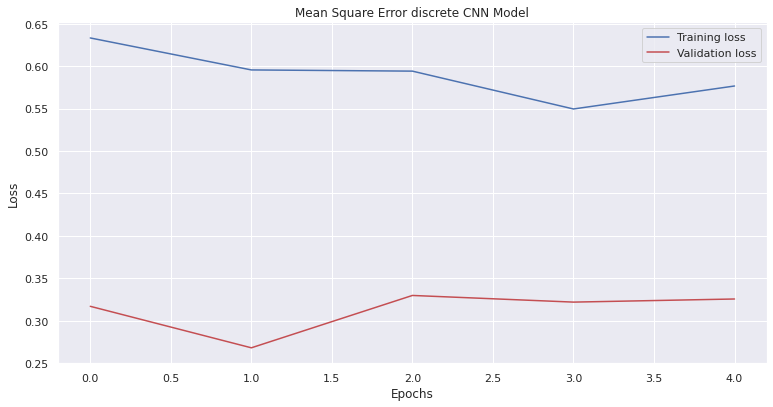

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, f"Mean Square Error {model_type[-1]} CNN Model")

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.ylim([0, 5])
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

if model_type[-1]=='discrete':
  dataset_train, dataset_val, dataset_test = generate_classical_dataset(1, 1)

elif model_type[-1]=='time-window':
  dataset_train, dataset_val, dataset_test = generate_classical_dataset(3, 1)

for x, y in dataset_test.take(200):
    show_plot(
        [x[0][:, 4].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [ ]:
plt.clf()

if model_type[-1]=='discrete':
  dataset_train, dataset_val, dataset_test = generate_classical_dataset(1, 1)

elif model_type[-1]=='time-window':
  dataset_train, dataset_val, dataset_test = generate_classical_dataset(3, 1)

metrics = pd.DataFrame(columns=["TYPE", "sample", "MAPE",
                                "Accuracy%", "RMSE", "RMSE%", "MAE", "MAE%"])
update_sample('in_sample')
errors = []
actual = []
predicted = []

for x, y in dataset_val.take(200):
    errors.append(y[0].numpy()[0]- model.predict(x)[0][0])
    actual.append(y[0].numpy()[0])
    predicted.append(model.predict(x)[0][0])

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual
results["Predicted"] = predicted
sns.set(rc={'figure.figsize':(12.7,6.27)})
sns.lineplot(data=results,palette="deep").set_title(sample[-1]+"_classical_"+model_type[-1]+"_cnn_forecast")
plt.savefig(sample[-1]+"_classical_"+model_type[-1]+"_cnn_forecast"+ ".png")

plt.clf()


errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = 100*rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = 100*np.mean(np.abs(errors))/np.mean(actual)
accuracy = 100 - 100*mape



metrics = metrics.append({"type":model_type[-1], "sample":sample[-1],
                          "MAPE": mape, "Accuracy%": accuracy, 
                          "RMSE":rmse, "RMSE%":rmse_percent,
                          "MAE":mae, "MAE%":mae_percent}, ignore_index=True )

update_sample('out_of_sample')
errors = []
actual = []
predicted = []
for x, y in dataset_test.take(200):

    errors.append(y[0].numpy()[0]- model.predict(x)[0][0])
    actual.append(y[0].numpy()[0])
    predicted.append(model.predict(x)[0][0])

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual
results["Predicted"] = predicted
sns.set(rc={'figure.figsize':(12.7,6.27)})
sns.lineplot(data=results,
             palette="deep").set_title(
                 sample[-1]+"_classical_"+model_type[-1]+"_cnn_forecast")
             
plt.savefig(sample[-1]+"_classical_"+model_type[-1]+"_cnn_forecast"+ ".png")

plt.clf()


errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = 100*rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = 100*np.mean(np.abs(errors))/np.mean(actual)
accuracy = 100 - 100*mape

metrics = metrics.append({"type":model_type[-1], "sample":sample[-1],"MAPE": mape, 
                          "Accuracy%": accuracy, "RMSE":rmse, 
                          "RMSE%":rmse_percent, "MAE":mae,
                          "MAE%":mae_percent}, ignore_index=True )

metrics.to_csv("classical_cnn_"+model_type[-1]+".csv")
metrics.head()

model.save("./saved_models/classical_"+model_type[-1]+"_cnn_model")

name = "classical_"+model_type[-1]+"_cnn_model"
origin_path = "./saved_models/"+name
target_path = "./"+name+".zip"
!zip -r $target_path $origin_path


INFO:tensorflow:Assets written to: ./saved_models/classical_discrete_cnn_model/assets
updating: saved_models/classical_discrete_cnn_model/ (stored 0%)
updating: saved_models/classical_discrete_cnn_model/assets/ (stored 0%)
updating: saved_models/classical_discrete_cnn_model/keras_metadata.pb (deflated 89%)
updating: saved_models/classical_discrete_cnn_model/variables/ (stored 0%)
updating: saved_models/classical_discrete_cnn_model/variables/variables.data-00000-of-00001 (deflated 11%)
updating: saved_models/classical_discrete_cnn_model/variables/variables.index (deflated 64%)
updating: saved_models/classical_discrete_cnn_model/saved_model.pb (deflated 89%)


<Figure size 914.4x451.44 with 0 Axes>

In [ ]:
## PUSH TO GITHUB


'time-window'

In [ ]:
model_type

['time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'time-window',
 'discrete',
 'discrete',
 'discrete',
 'discrete',
 'discrete',
 'discrete',
 'discrete',
 'time-window',
 'discrete',
 'discrete',
 'discrete',
 'discrete']